# Gold nanoparticle validation

Plasmonic nanoparticles can exhibit interesting electromagnetic properties at certain frequencies, such as a negative real part of the relative permittivty. Due to their high electrical conductivity, gold nanoparticles can be challenging to model: the rapid field variations inside and near the particles require a fine local discretization. Therefore, an intelligent non-uniform meshing scheme is essential to make sure that the particle is well resolved, while ensuring that the empty space around it does not lead to wasted simulation effort.

Scattering from a 10 nm gold sphere is modeled in this example, and results are compared to the analytical Mie series. This example uses the total-field-scattered-field ([TFSF](../_autosummary/tidy3d.TFSFSource)) source to excite the particle, and illustrates how to compute various quantities like the total absorbed power, total scattering cross-section, and forward cross-section. A non-uniform mesh is carefully designed to make sure the sphere is well resolved without a significant sacrifice in efficiency.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

[18:18:37] WARNING  This version of Tidy3D was pip installed from the         ]8;id=373739;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=236054;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#101\101]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

           INFO     Using client version: 1.10.0rc2                           ]8;id=63702;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=824363;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#116\116]8;;\

## Define the structure and boundary conditions
Note the special treatment in creating the mesh: we need to make sure that the mesh is sufficiently fine within the sphere, but we can also make use of `Tidy3D`'s non-uniform meshing algorithm to have a coarser grid outside the sphere, for better efficiency. Furthermore, the TFSF source works best if placed in a region with uniform mesh. Because of this, we will add a mesh override structure which is slightly larger than the sphere itself.

In [2]:
# radius and location of the nanoparticle
radius = 5e-3
center = [0, 0, 0]

# nanoparticle material
medium = td.material_library["Au"]["RakicLorentzDrude1998"]

# free space central wavelength of the pulse excitation
wavelength = 530e-3
f0 = td.C_0 / wavelength

# bandwidth in Hz
fwidth = f0 / 5.0
fmin = f0 - fwidth
fmax = f0 + fwidth
wavelength_max = td.C_0 / fmin
wavelength_min = td.C_0 / fmax

# distance between particle and the boundary of the tfsf box
buffer_tfsf = 0.3 * radius
tfsf_size = (radius + buffer_tfsf) * 2

# distance between the particle and the scattered field region monitors (should be larger than buffer_tfsf)
buffer_out = 0.4 * radius
out_size = (radius + buffer_out) * 2

# distance between the particle and the total field region monitor (should be smaller than buffer_tfsf)
buffer_in = 0.2 * radius
in_size = (radius + buffer_in) * 2

# distance between particle and the mesh override region
buffer_override = 0.8 * radius
override_size = (radius + buffer_override) * 2

# The nanoparticle is very electrically small in the frequency range considered here, and meshing
# based on a standard 10-30 points per wavelength would lead to a grid too coarse to resolve the
# curvature of the sphere. Instead, we just define how many cells we want within the sphere diameter
# by creating a mesh override region
cells_per_wavelength = 100 # for meshing outside of the particle
cells_in_particle = 60    # for the mesh override region
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=center, size=(override_size, ) * 3),
    dl = (2 * radius / cells_in_particle,) * 3
)

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=medium)
geometry = [sphere]

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_pml = wavelength_max / 2

# set the full simulation size along x, y, and z
sim_size = [(radius + buffer_pml) * 2] * 3

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())


## Create Source

For our incident field, we use a TFSF source to inject a plane wave incident from below the sphere polarized in the x direction.

In [3]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# the tfsf source is defined as a box around the particle
source = td.TFSF(
    center=center,
    size=(tfsf_size,) * 3,
    source_time=gaussian,
    injection_axis=2, # inject along the z axis...
    direction='+',    # ...in the positive direction, i.e. along z+
    name='tfsf',
    pol_angle=0,
)

# Simulation run time
run_time = 10 / fwidth

## Create Monitors

Next, we define a number of monitors to analyze the simulation.

- A 3D FluxMonitor inside the TFSF source can be used to compute the power absorbed in the particle. If no power is absorbed, the recorded flux would be 0, since there are no power sources or sinks inside the monitor box. Any flux recorded in the FluxMonitor is then due to the imbalance between the incoming power and the outgoing one, which has been reduced by the particle absorption.

- A 3D FluxMonitor outside the TFSF region can be used to compute the total cross-section, meaning the total power of scattered radiation in all directions.

- A [FieldProjectionAngleMonitor](../_autosummary/tidy3d.FieldProjectionAngleMonitor) can be used to compute the radiated cross-section at a particular angle.

- Finally, we also store the fields in a planar cross-section for visualization purposes.

In [4]:
# set the list of frequencies at which to compute quantities
num_freqs = 100
freqs = np.linspace(f0 - fwidth, f0 + fwidth, 100)

monitor_flux_out = td.FluxMonitor(
    size=[out_size] * 3,
    freqs=freqs,
    name="flux_out",
)
monitor_flux_in = td.FluxMonitor(
    size=[in_size] * 3,
    freqs=freqs,
    name="flux_in",
)

# Create near field to far field projection monitor for forward RCS
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=center,
    size=[out_size] * 3,
    freqs=freqs,
    name="n2f",
    phi=[0],
    theta=[0],
)

# Near field monitor for visualization
monitor_near = td.FieldMonitor(
    center=[0, 0, 0],
    size=[out_size, 0, out_size],
    freqs=[f0],
    name="near",
)

monitors = [monitor_flux_out, monitor_flux_in, monitor_n2f, monitor_near]


## Create Simulation

Now we can put everything together and define the simulation.

In [5]:
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[mesh_override],
)

sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    shutoff=1e-8,
)

## Visualize Geometry and Mesh

Let's take a look at the mesh and geometry and make sure everything is defined properly in the simulation. The nanoparticle is very small compared to the simulation and is not visible in the full plot. For better visibility, we also show a zoomed-in plot, which shows how the nanoparticle is meshed. Note that the mesh inside the nanoparticle is quite fine and may not render correctly in the notebook, possibly giving the false impression of being somewhat coarse.

           INFO     Auto meshing using wavelength 0.5300 defined from        ]8;id=468659;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=134680;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#539\539]8;;\
                    sources.                                                                 

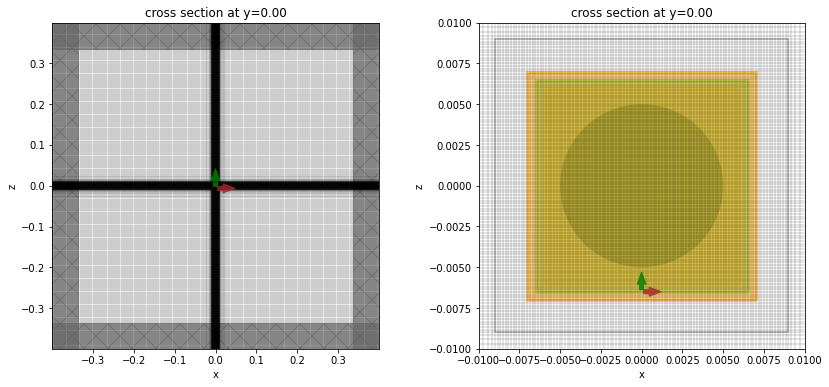

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sim.plot(y=0, ax=ax1)
sim.plot_grid(y=0, ax=ax1)
sim.plot(y=0, ax=ax2, monitor_alpha=0.2)
sim.plot_grid(y=0, ax=ax2)
zoom = radius * 2
ax2.axis([-zoom, zoom, -zoom, zoom]);

## Run Simulation


In [7]:
# Run simulation
sim_data = web.run(
    sim, task_name="plasmonic_nanoparticle", path="data/plasmonic_nanoparticle.hdf5"
)

[18:18:38] INFO     Created task 'plasmonic_nanoparticle' with task_id          ]8;id=819922;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=49845;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#126\126]8;;\
                    'fdve-60084b78-1a2e-48c1-8897-82726ffa4e78v1'.                           

Output()

[18:18:40] INFO     status = queued                                             ]8;id=848503;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=878610;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#251\251]8;;\

Output()

[18:18:45] INFO     status = preprocess                                         ]8;id=430739;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=616146;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#244\244]8;;\

[18:18:48] INFO     Maximum FlexUnit cost: 1.989. Use 'web.real_cost(task_id)'  ]8;id=838335;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=582559;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#268\268]8;;\
                    to get the billed FlexUnit cost after a simulation run.                  

           INFO     starting up solver                                          ]8;id=643606;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=739046;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#272\272]8;;\

[18:26:09] INFO     running solver                                              ]8;id=838949;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=59911;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\

Output()

[18:26:10] INFO     status = postprocess                                        ]8;id=170942;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=528677;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#312\312]8;;\

Output()

[18:26:15] INFO     status = success                                            ]8;id=729181;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=668939;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#319\319]8;;\

Output()

[18:26:17] INFO     loading SimulationData from                                 ]8;id=159242;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=225849;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#493\493]8;;\
                    data/plasmonic_nanoparticle.hdf5                                         

## Extract the results

In [12]:
# Total absorbed power
absorbed = np.abs(sim_data["flux_in"].flux)

# Total scattered power
scattered = sim_data["flux_out"].flux

# Power scattered in the forward direction
RCS = np.squeeze(np.real(sim_data["n2f"].radar_cross_section.values))

## Plot Results and Compare with Mie Series

The final results are compared against the analytical Mie series below, and very good agreement is observed. The small deviations can be reduced with a further refinement of the grid. Since the sphere's material is dispersive, no subpixel averaging scheme is applied, so the simulation approximates the curved permittivity profile in a staircase-like manner, which contributes to the error.

           INFO     Auto meshing using wavelength 0.5300 defined from        ]8;id=973497;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=75890;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#539\539]8;;\
                    sources.                                                                 

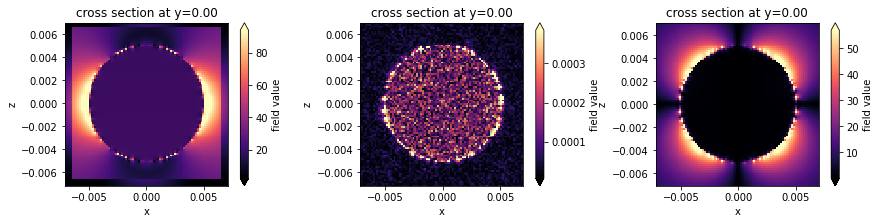

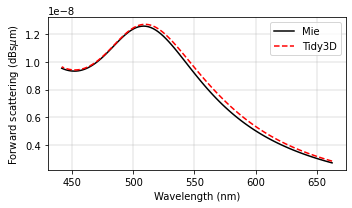

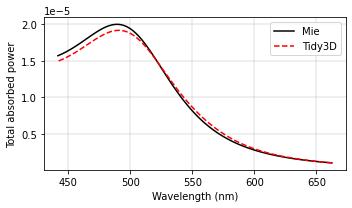

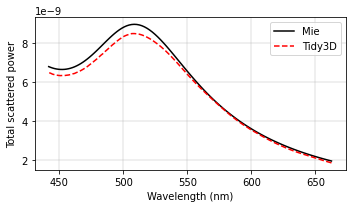

In [13]:
# load Mie series data
savefile_flux_abs = "./data/mie_plasmonic_flux_abs.txt"
savefile_flux_scat = "./data/mie_plasmonic_flux_scat.txt"
savefile_RCS = "./data/mie_plasmonic_RCS.txt"

flux_abs_mie = np.loadtxt(savefile_flux_abs, delimiter="\t", skiprows=1)[:, 1]
flux_scat_mie = np.loadtxt(savefile_flux_scat, delimiter="\t", skiprows=1)[:, 1]
RCS_mie = np.loadtxt(savefile_RCS, delimiter="\t", skiprows=1)[:, 1]

def to_db(val):
    return val
    return 10.0 * np.log10(val)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sim_data.plot_field(
    field_monitor_name="near", field_name="Ex", val="abs", f=f0, ax=ax[0]
)
sim_data.plot_field(
    field_monitor_name="near", field_name="Ey", val="abs", f=f0, ax=ax[1]
)
sim_data.plot_field(
    field_monitor_name="near", field_name="Ez", val="abs", f=f0, ax=ax[2]
)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, to_db(RCS_mie), "-k", label="Mie")
ax.plot(td.C_0 / freqs * 1e3, to_db(RCS), "--r", label="Tidy3D", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Forward scattering (dBs$\\mu$m)",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, flux_abs_mie, '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, absorbed, "--r", label="Tidy3D", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Total absorbed power",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, flux_scat_mie, '-k', label="Mie")
ax.plot(td.C_0 / freqs * 1e3, scattered, "--r", label="Tidy3D", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Total scattered power",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout();
